In [1]:
import numpy as np
import open3d as o3d
import copy
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

references:

> https://stackoverflow.com/questions/47932955/how-to-check-if-a-3d-point-is-inside-a-cylinder
> https://math.stackexchange.com/questions/3518495/check-if-a-general-point-is-inside-a-given-cylinder

## File IO

In [2]:
stl_mesh = o3d.io.read_triangle_mesh("models/stl_mesh.stl")
obj_mesh = o3d.io.read_triangle_mesh("models/obj_mesh.obj")

## Visualization

In [6]:
mesh = o3d.io.read_triangle_mesh("models/stl_mesh.stl")
# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

In [7]:
# o3d.visualization.draw_geometries([mesh, mesh_frame])

In [8]:
# scaled_mesh = copy.deepcopy(mesh)
# scaled_mesh.scale(1 / np.max(scaled_mesh.get_max_bound() - scaled_mesh.get_min_bound()), center=scaled_mesh.get_center())
# o3d.visualization.draw_geometries([scaled_mesh, mesh_frame])

## Normalization

### Center the Mesh

In [9]:
print(mesh.get_center())
centered_vertices = np.array(mesh.vertices) - mesh.get_center()
mesh.vertices = o3d.utility.Vector3dVector(centered_vertices)
print(mesh.get_center())

[4.43705180e-05 0.00000000e+00 1.34908065e-02]
[-4.69554972e-16  0.00000000e+00  7.46161023e-16]


### Scale the Points

In [10]:
print(mesh.get_min_bound(), mesh.get_max_bound())
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
print(mesh.get_min_bound(), mesh.get_max_bound())

[-0.03178843 -0.0015875  -0.04524081] [0.03169969 0.0015875  0.07236666]
[-0.27029265 -0.01349829 -0.38467632] [0.26953809 0.01349829 0.61532368]


In [11]:
# o3d.visualization.draw_geometries([mesh, mesh_frame])

## Normals Visualization

In [12]:
# print(np.array(stl_mesh.vertices).shape)
# print(np.array(stl_mesh.triangles).shape)
# print(np.array(stl_mesh.vertex_normals).shape)
# print(np.array(stl_mesh.triangle_normals).shape)
# print(stl_mesh.has_triangle_normals())
# print(stl_mesh.has_vertex_normals())

# print(stl_mesh.compute_triangle_normals())
# print(stl_mesh.compute_vertex_normals())

In [14]:
mesh.compute_triangle_normals()
triangle_normals = np.array(mesh.triangle_normals)

indices = list(range(0, triangle_normals.shape[0], 100))
triangle_normals_subset = triangle_normals[indices]

fromm = [0] * triangle_normals_subset.shape[0]
to = list(range(1, triangle_normals_subset.shape[0] + 1))

points = np.insert(triangle_normals_subset, 0, [0, 0, 0], axis=0)
lines = list(zip(fromm, to))


line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines)
)

line_set.scale(1.2, [0, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
o3d.visualization.draw_geometries([mesh, line_set])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


## Voxelization and Holes

### V1: Using 3D Points and  Voxels

In [140]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.02)
# o3d.visualization.draw_geometries([voxel_grid])

In [ ]:
voxels = np.array(list(map(lambda x: x.grid_index, voxel_grid.get_voxels())))

In [2]:
def points_in_cylinder(pt1, pt2, radius, points):
    """
    find the points in a cylinder
    :pt1: 1st bounding point of the cylinder
    :pt2: 2nd bounding point of the cylinder
    :radius: radius of the cylinder
    :points: NumPy array of 3D points
    :return: NumPy boolean array of points inside of cylinder
    """
    vec = pt2 - pt1
    const = radius * np.linalg.norm(vec)
    cond1 = np.dot(points - pt1, vec) >= 0
    cond2 = np.dot(points - pt2, vec) <= 0
    cond3 = np.linalg.norm(np.cross(points - pt1, vec), axis=1) <= const
    
    cond4 = np.logical_and(cond1, cond2)
    cond5 = np.logical_and(cond3, cond4)
    return cond5

In [48]:
points = np.asarray(mesh.vertices)

maxx = np.max(points, axis=0)
minn = np.min(points, axis=0)

pt1 = voxel_grid.get_center()
pt2 = voxel_grid.get_center()

idx = 2
pt1[idx] =  minn[idx]
pt2[idx] =  maxx[idx]

In [49]:
idx = points_in_cylinder(pt1, pt2, 0.05, points)
to_be_removed = points[idx]

In [50]:
voxels_to_be_removed = np.unique(list(map(lambda x: voxel_grid.get_voxel(x), to_be_removed)), axis = 0)

In [51]:
# voxels_to_be_removed = list(map(lambda x: o3d.geometry.Voxel(x), voxels_to_be_removed))

In [52]:
N = voxels.max()
voxels_occ_grid = np.zeros((N,N,N))

In [53]:
for v in voxels:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 1

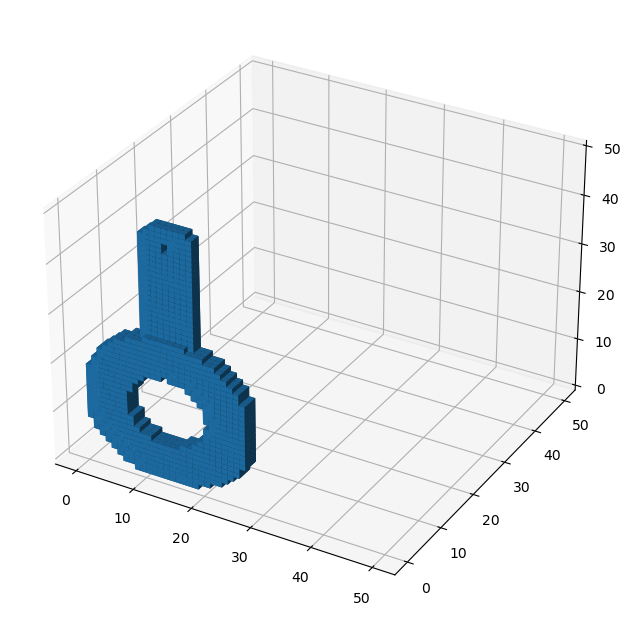

In [54]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()

In [55]:
for v in voxels_to_be_removed:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 0

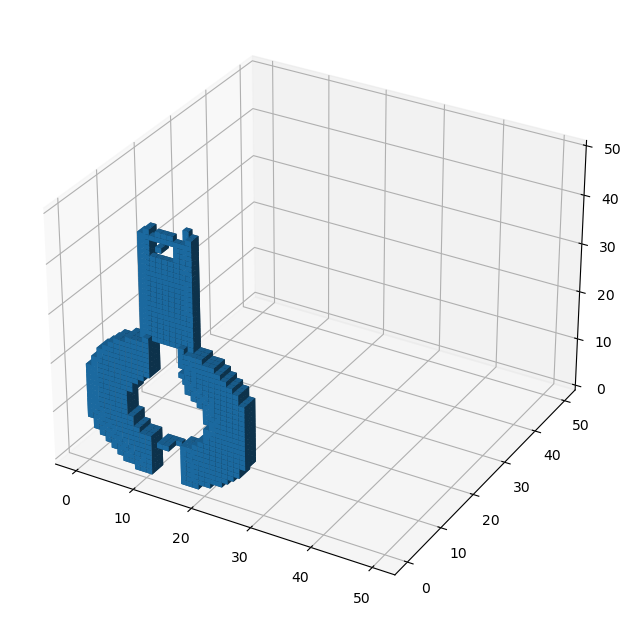

In [56]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()

### V2: Using Voxels

In [129]:
# get the voxel grid indices out of the occupancy grid
model = np.load("models/top_20_models_voxelized/20.npz")['model']
voxels = np.argwhere(model == 1)

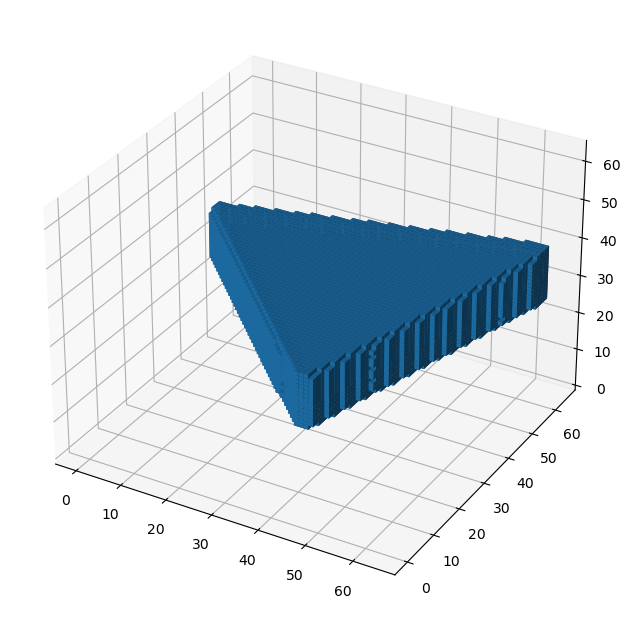

In [122]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(model)
plt.show()

In [130]:
def find_radius(voxels, cylinder_axis):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :cylinder_axis: axis of the cylinder {0, 1, 2}
    :return: selected radius
    """
    # list of possible diameters [2, 10]
    diameters = list(range(10, 1, -1))
    
    # 2d plane perpendicular to the cylinder axis
    plane = list(range(3))
    plane.remove(cylinder_axis)    

    # maximum and minimum grid index 
    maxx = np.max(voxels, axis=0)
    minn = np.min(voxels, axis=0)
    
    # perpendicular plane dimensions 
    fir_dim = maxx[plane[0]] - minn[plane[0]]
    sec_dim = maxx[plane[1]] - minn[plane[1]]
    
    # perpendicular plane smaller dimension
    min_dim = np.min([fir_dim, sec_dim])

    # heuristic: there should be more than 10 voxels after making the hole
    for d in diameters:
        diff = min_dim - d
        if diff > 10:
            return int(d/2)
        
    return None

In [131]:
def find_axis_and_radius_greedy(voxels):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :return: pair: selected axis and radius
    """
    # try out the 3 possible axes
    axis = range(3)
    for a in axis:
    # return 1st axis with largest diameter
        r = find_radius(voxels, a)
        print(a, r)
        if r != None:
            return a, r
    # return None if no appropriate radius and axis were found    
    return None, None

In [132]:
def find_axis_and_radius_exhaustive(voxels):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :return: pair: selected axis and radius
    """
    # try out the 3 possible axes
    axis = range(3)
    result = []
    for a in axis:
        r = find_radius(voxels, a)
        print(a, r)
        result.append(r)
    
    # replace None with -1 to compute max
    result = [x or -1 for x in result]
    axis, radius = np.argmax(result), np.max(result)
    
    radius = -1
    
    # return None if no appropriate radius and axis were found
    if radius == -1: 
        axis, radius = None, None
    
    return axis, radius

In [137]:
# find appropriate axis and radius of the cylinder
axis, radius = find_axis_and_radius_exhaustive(voxels)
print("selected:", axis, radius)

0 1
1 1
2 5
selected: None None


In [134]:
if axis != None and radius != None:
    # find center of the voxels grid
    center = np.round(voxels.mean(axis = 0))

    # maximum and minimum grid index 
    maxx = np.max(voxels, axis=0)
    minn = np.min(voxels, axis=0)

    # set cylinder boundary points to the center
    pt1 = copy.deepcopy(center)
    pt2 = copy.deepcopy(center)

    # change 1 component based on the selected axis
    idx = axis
    pt1[idx] =  minn[idx]
    pt2[idx] =  maxx[idx]

    # identify voxels to be removed
    idx = points_in_cylinder(pt1, pt2, radius, voxels)
    to_be_removed = voxels[idx]

    # remove selected voxels from the occupancy grid
    for v in to_be_removed:
        model[v[0], v[1], v[2]] = 0
else:
    print("hole creation not possible")

hole creation not possible


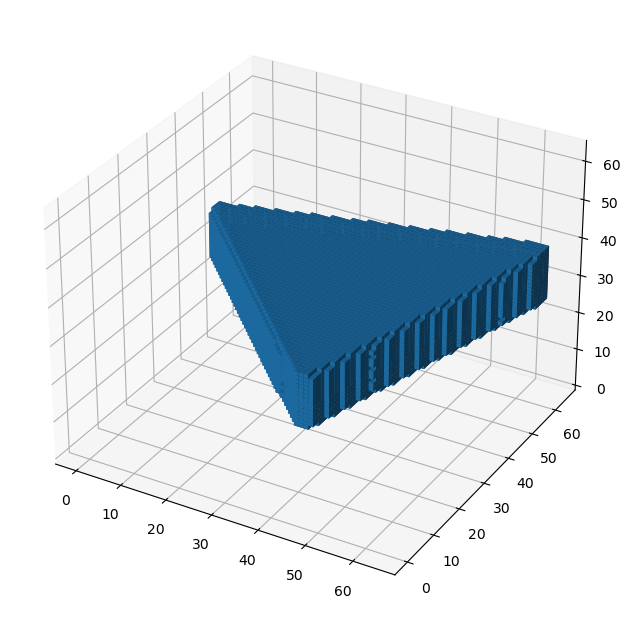

In [135]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(model)
plt.show()

## Hole through Min MOI Axis

In [6]:
points = np.asarray(voxels)
points_squared = np.square(points)

In [7]:
# horizontal sum of Y and Z components
I_xx = points_squared[:, 1:].sum(axis=1)
# vertical sum
I_xx = I_xx.sum(axis=0)

# horizontal product of X and Y components
I_xy = points[:, 0] * points[:, 1]
# vertical sum
I_xy = -I_xy.sum(axis=0)

# horizontal product of X and Z components
I_xz = points[:, 0] * points[:, 2]
# vertical sum
I_xz = -I_xz.sum(axis=0)

# horizontal sum of X and Z components
I_yy = points_squared[:, 0] + points_squared[:, 2]
# vertical sum
I_yy = I_yy.sum(axis=0)

# horizontal product of Y and Z components
I_yz = points[:, 1] * points[:, 2]
# vertical sum
I_yz = -I_yz.sum(axis=0)

# horizontal sum of X and Y components
I_zz = points_squared[:, 0] + points_squared[:, 1]
# vertical sum
I_zz = I_zz.sum(axis=0)

In [8]:
inertia_tensor = np.array([[I_xx, I_xy, I_xz], [I_xy, I_yy, I_yz], [I_xz, I_yz, I_zz]])
eigen_values, eigen_vectors = np.linalg.eigh(inertia_tensor)
min_eigen_value_index = eigen_values.argmin()
min_MOI_axis = eigen_vectors[:, min_eigen_value_index]

In [9]:
def align_vectors_v2(a, b):
    a = a / np.linalg.norm(a) # normalize a
    b = b / np.linalg.norm(b) # normalize b
    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)

    v1, v2, v3 = v
    h = 1 / (1 + c)

    Vmat = np.array([[0, -v3, v2],
                  [v3, 0, -v1],
                  [-v2, v1, 0]])

    R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
    return R

In [10]:
axis = np.array([0., 1., 0.])
rotation = align_vectors_v2(min_MOI_axis, axis)

In [17]:
min_MOI_axis = rotation.dot(min_MOI_axis)
voxels = np.round(voxels.dot(rotation)).astype(int)

In [24]:
N = voxels.max()
voxels_occ_grid = np.zeros((N,N,N))

In [25]:
for v in voxels:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 1

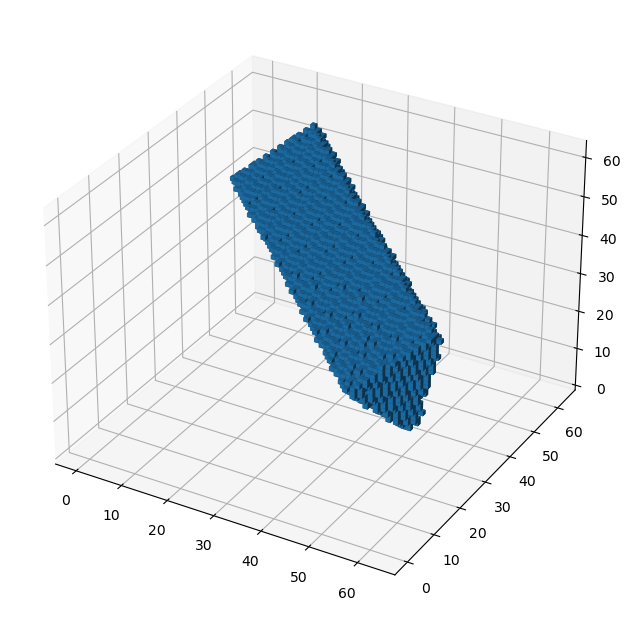

In [26]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()